In [747]:
# IMPORTS & UNITS

#---------------------------------------
import numpy as np
from matplotlib import pyplot as plt
from astropy import constants as const

# Relevant constants in CGS
G = const.G.cgs
M_sun = const.M_sun.cgs
kpc = const.kpc.cgs

# Internal units conversion factors: G = 1, M = 1 M_sun, r = 1 kpc
v_I_to_v_cgs = (G * M_sun / kpc) ** (1 / 2)
t_I_to_t_cgs = kpc / v_I_to_v_cgs

mass_unit_str = "$M_\odot$"
distance_unit_str = "$kpc$"

<>:17: SyntaxWarning: invalid escape sequence '\o'
<>:17: SyntaxWarning: invalid escape sequence '\o'
/var/folders/05/2fbv44555hx420qclxnfbd4c0000gn/T/ipykernel_33561/441333738.py:17: SyntaxWarning: invalid escape sequence '\o'
  mass_unit_str = "$M_\odot$"


In [748]:
print(v_I_to_v_cgs)
print(t_I_to_t_cgs)

207.38652969844205 cm / s
1.4878871766542453e+19 s


In [749]:
# INPUT READING FUNCTIONS

#---------------------------------------------
# Read the input file:
#
# N = number of particles
# t_0 = initial time
# particles_0 = collection of mass + 6D position/velocity vector for every particle in the system
# The shape of particles is: [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                             ...,
#                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]
#
# Returns:
#         N
#         a snapshot ("snapshot_0") of the system at the initial condition in the shape:
#         [N, t_0, particles_0] :   [N, t_0, [[m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1], 
#                                             [m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2],
#                                             ...,
#                                             [m_N x_N, y_N, z_N, vx_N, vy_N, vz_N]]]
#
# Input file is structured as follow:
#
# N
# t_0
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
def read_input(input_file_path):
    input_file = open(input_file_path)

    # readline() reads the first line and returns it as a string
    N = int(input_file.readline())
    t_0 = float(input_file.readline())

    # readlines() reads all the remaining lines and returns them into a list of strings
    particles_0 = input_file.readlines()

    input_file.close()

    # Convert the list of strings into a list of lists of number
    for i in range(len(particles_0)):
        # split() splits a string based on a separator (default is ' ') and returns a list of strings
        particles_0[i] = particles_0[i].split()

        # Convert the elements of each splitted string into numbers
        for j in range(len(particles_0[i])):
            particles_0[i][j] = float(particles_0[i][j])

    snapshot_0 = [N, t_0, particles_0]

    return snapshot_0

#-----------------------------------------------------------------------------
# Read the output file:
# # Output file is structured as follow:
#
# N
# t_1
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
# N
# t_2
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# ...
#
# N
# t_f
# m_1 x_1, y_1, z_1, vx_1, vy_1, vz_1
# m_2 x_2, y_2, z_2, vx_2, vy_2, vz_2
# ...
# m_N x_N, y_N, z_N, vx_N, vy_N, vz_N
#
# Returns a list of snapshot of the evolved system (t>t_0)
# See read_input for details on the snapshots
def read_output(output_file_path):
    output_file = open(output_file_path)

    # List to store all the snapshots in the output file
    snapshots = []

    # Try except here detects the EOF
    # int() throws an exception when tries to convert something different than a number
    while True:
        try:
            N = int(output_file.readline())
        except:
            break

        # Line after N is the time stamp of the snapshot
        t_stamp = float(output_file.readline())

        # Collect strings of mass + 6D position/velocity vector N times (for N particles)
        particles = [output_file.readline() for i in range (N)]

        # Convert the list of strings into a list of lists of number (same as for read_input())
        for i in range(len(particles)):
            particles[i] = particles[i].split()

            for j in range(len(particles[i])):
                particles[i][j] = float(particles[i][j])
        
        # Append the snapshot [t_stamp, particles] to the snapshots list
        snapshots.append([N, t_stamp, particles])

    output_file.close()
    
    return snapshots

#--------------------------------------------------------------------------
# Returns:
#         N
#         The complete list of snapshots of the system (including the initial one)
#
# How to navigate the snapshots:
# 1) Choose the snapshot:
#    *** snapshots[snapshot_index, from 0 to len(snapshot)-1] ***
#
# 2) What do you want?
#    A) Number of particles:
#       *** snapshot[snapshot_index][0] ***
#       Note that snapshot[snapshot_index][0] can't be subscripted anymore
#
#    B) Time stamp: 
#       *** snapshot[snapshot_index][1] ***
#       Note that snapshot[snapshot_index][1] can't be subscripted anymore
#
#    C) Particles masses, positions and velocities:
#       *** snapshot[snapshot_index][2] ***
#       This is a list of lists (see read_input() for details)
#
# 3) Which particle are you interested in?
#    *** snapshot[snapshot_index][2][particle_index, from 0 to N-1] ***
#
# 4) What do you want to know about the particle:
#    *** Mass: snapshot[snapshot_index][2][particle_index][0] ***
#    *** x, y, z: snapshot[snapshot_index][2][particle_index][1, 2, 3] ***
#    *** vx, vy, vz: snapshot[snapshot_index][2][particle_index][1+3, 2+3, 3+3] ***
def read_snapshots(input_file_path, output_file_path):
    snapshot_0 = read_input(input_file_path)
    snapshots = read_output(output_file_path)

    # Append the intial snapshot to the beginning of the list
    snapshots = [snapshot_0] + snapshots

    return snapshots

In [750]:
# MATHEMATICAL COMPUTATIONAL FUNCTIONS

#-------------------------------------------------------------------------
# Returns the difference between two vectors (vector_2 - vector_1)
# 
# If vectors are positions:
# It is a vector that points from position_1 to position_2: [x_2 - x_1, y_2 - y_1, z_2 - z_1]
# 
# If vectors are velocities:
# It is a vectors that describes the relative velocity in the frame in which particle 1 is at rest
# [vx_2 - vx_1, vy_2 - vy_1, vz_2 - vz_1]
#
# Imput parameters are strictly numpy arrays of 3 numbers: (x, y, z)
def compute_vector_diff(vector_1, vector_2):
    return vector_2 - vector_1

# Returns the distance between two points
# Imput parameters are arrays of 3 numbers: (x, y, z)
def compute_distance(point_1, point_2):
    distance = 0
    for i in range (3):
        distance += (point_1[i] - point_2[i]) ** 2
    
    return distance ** (1 / 2)

In [751]:
# SNAPSHOTS READING FUNCTIONS & SMALL CALCULATIONS

#------------------------------------------------------------------
# Returns an array of the number of particles of the snapshots
def get_N(snapshots):
    return np.array([snapshots[i][0] for i in range(len(snapshots))])

# Returns an array of the time stamps of the snapshots
def get_timestamps(snapshots):
    return np.array([snapshots[i][1] for i in range(len(snapshots))])

# Returns an array of the masses of the specified snapshot
def get_masses(snapshots, snapshot_index=0):
    return np.array([snapshots[snapshot_index][2][i][0]
                     for i in range(len(snapshots[snapshot_index][2]))])

# Compute the position or velocity of the center of mass for the specified snapshot
# Returns an array of 3 values: [qt_x, qt_y, qt_z]
# vec = 'pos', 'vel'
def get_center_of_mass(snapshots, snapshot_index=0, vec=''):
    M_tot = np.sum(get_masses(snapshots, snapshot_index))
    qtX_CM, qtY_CM, qtZ_CM = 0, 0, 0

    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3

    for i in range(snapshots[snapshot_index][0]):
        qtX_CM += snapshots[snapshot_index][2][i][0] * snapshots[snapshot_index][2][i][1+shift]
        qtY_CM += snapshots[snapshot_index][2][i][0] * snapshots[snapshot_index][2][i][2+shift]
        qtZ_CM += snapshots[snapshot_index][2][i][0] * snapshots[snapshot_index][2][i][3+shift]
    
    qtX_CM /= M_tot
    qtY_CM /= M_tot
    qtZ_CM /= M_tot

    return np.array([qtX_CM, qtY_CM, qtZ_CM])

# absval = 0: returns an array of 3D vectors of the specified particle, for the specified quantity
#             in the specified reference frame
# [[Qx1_0, Qy_0, Qz_0], [Qx_1, Qy_1, Qz_1], ..., [len(snapshots)-1]]
# absval = n != 0: returns the absolute value of the vectors to the absval-th power
# vec = 'pos', 'vel'
# rf = 'snapshot', 'cm' (center of mass)
def get_3D_vec(snapshots, particle_index, vec='', absval=0, rf='snapshot', rf_particle_index=None):
    if vec.lower() == 'pos':
        shift = 0
    elif vec.lower() == 'vel':
        shift = 3
    
    # Compute in the snapshot reference frame
    if rf.lower() == 'snapshot':
        result = np.array([snapshots[i][2][particle_index][1+shift:4+shift]
                           for i in range(len(snapshots))])
    
    # Compute in the center of mass reference frame
    elif rf.lower() == 'cm':
        result = compute_vector_diff(np.array([get_center_of_mass(snapshots, i, vec)
                                               for i in range(len(snapshots))]),
                                               np.array([snapshots[i][2][particle_index][1+shift:4+shift]
                                                         for i in range(len(snapshots))]))
    
    # Compute in the reference frame of the specified particle
    elif rf.lower() == 'particle':
        result = compute_vector_diff(np.array([snapshots[i][2][rf_particle_index][1+shift:4+shift]
                                               for i in range(len(snapshots))]),
                                               np.array([snapshots[i][2][particle_index][1+shift:4+shift]
                                                         for i in range(len(snapshots))]))

    # Return the result as it is
    if absval == 0:
        pass
    
    # Compute the absval-th power of every vector into "result"
    elif absval != 0:
        for i in range(len(result)):
            vec_value = 0
            for j in range(3):
                vec_value += result[i][j] ** 2

            vec_value = vec_value ** (1 / 2)
            
            result[i] = vec_value ** absval

        # Because of how numpy arrays works, we need to slice the array to take the first column
        # Actually any column would be fine because now their content is equal
        # The point is that we want just one set of values and not three
        result = result[:, :1]

        # Slicing returns an array with shape [[x_0], [x_1], ..., [x_(len(snapshot)-1)]]
        # Redefine the array to get rid of the 1-element lists
        result = np.array([result[i][0] for i in range(len(result))])

    return result

# Returns an array of the specified coordinate for the specified particle for the specified quantity
# vec = 'pos', 'vel'
# axe = 'x', 'y', 'z'
def get_coord(snapshots, particle_index, vec='', axe=''):
    if axe.lower() == 'x':
        coordinates = get_3D_vec(snapshots, particle_index, vec)[:, :1]
    elif axe.lower() == 'y':
        coordinates = get_3D_vec(snapshots, particle_index, vec)[:, 1:2]
    elif axe.lower() == 'z':
        coordinates = get_3D_vec(snapshots, particle_index, vec)[:, 2:3]

    return np.array([coordinates[i][0] for i in range(len(coordinates))])

In [752]:
# PHYSICS COMPUTATIONAL FUNCTIONS

#-------------------------------------------------------------------------
# Returns the energy of the system in the specified reference frame
# E_type = 'kin', 'pot', 'tot'
# rf = 'snapshot', 'cm' (center of mass)
def get_energy(snapshots, snapshots_index, E_type='', rf='snapshot', rf_particle_index=None):
    N = snapshots[snapshots_index][0]

    if E_type.lower() == 'kin':
        E = 0
        # A list of lists of the velociies squared of every massess at every time
        # [[vsq_t0_0, vsq_t1_0, ..., vsq_tf_0], [vsq_t0_1, vsq_t1_1, ..., vsq_tf_1], ..., [vsq_t_(N-1)]]
        v_squared = [get_3D_vec(snapshots, i, 'vel', 2, rf, rf_particle_index) for i in range (N)]

        for i in range(N):
            E += (1 / 2) * snapshots[snapshots_index][2][i][0] * v_squared[i][snapshots_index]
    elif E_type.lower() == 'pot':
        E = 0
        # Same as above but it's for position vectors
        # positions[i][snapshots_index] will be the 3D vector of the i-th particle at specified snapshot
        positions = [get_3D_vec(snapshots, i, 'pos', 0, rf, rf_particle_index) for i in range(N)]

        # Cycle over all possible combination of particles
        # part_0: part_1, part_2, part_3, ..., part_(N-1)
        # part_1: part_2, part_3, part_4, ..., part_(N-1)
        # part_2: part_3, part_4, part_5, ..., part_(N-1)
        # ...
        # part_i: part_(i+1), part_(i+2), ..., part_(N-1)
        for i in range(N):
            for j in range(i+1, N):
                distance = compute_distance(positions[i][snapshots_index], positions[j][snapshots_index])
                E += -1 * snapshots[snapshots_index][2][i][0] * snapshots[snapshots_index][2][j][0] / distance
    elif E_type.lower() == 'tot':
        E_kin = get_energy(snapshots, snapshots_index, 'kin', rf, rf_particle_index)
        E_pot = get_energy(snapshots, snapshots_index, 'pot', rf, rf_particle_index)
        E = E_kin + E_pot

    return E

In [753]:
# PROBLEM SPECIFIC FUNCTIONS

#-------------------------------------------------------
# Returns the apoastrom or the periastrom radius of the orbit of the specified particle
# It is computed as the maximum or the minimum distance of the particle from the center of mass
def get_aper(snapshots, particle_index, aper=''):
    CM_pos = [get_center_of_mass(snapshots, i, 'pos') for i in range(len(snapshots))]
    distances = [compute_distance(CM_pos[i],
                                  get_3D_vec(snapshots, particle_index, 'pos')[i])
                                  for i in range(len(snapshots))]

    if aper.lower() == 'apo':
        distance = np.max(distances)
    elif aper.lower() == 'per':
        distance = np.min(distances)

    return distance

# Returns the eccentricity of the orbit
def get_eccentricity(snapshots, particle_index):
    apo = get_aper(snapshots, particle_index, 'apo')
    per = get_aper(snapshots, particle_index, 'per')

    ratio = apo / per

    return 1 - 2 / (ratio + 1)

In [754]:
input_file_path = "input.txt"
output_file_path = "output.txt"

snapshots = read_snapshots(input_file_path, output_file_path)

pos = [[get_coord(snapshots, i, 'pos', 'x'), get_coord(snapshots, i, 'pos', 'y')] for i in range (2)]
vel = [[get_coord(snapshots, i, 'vel', 'x'), get_coord(snapshots, i, 'vel', 'y')] for i in range (2)]
time_stamp = get_timestamps(snapshots)

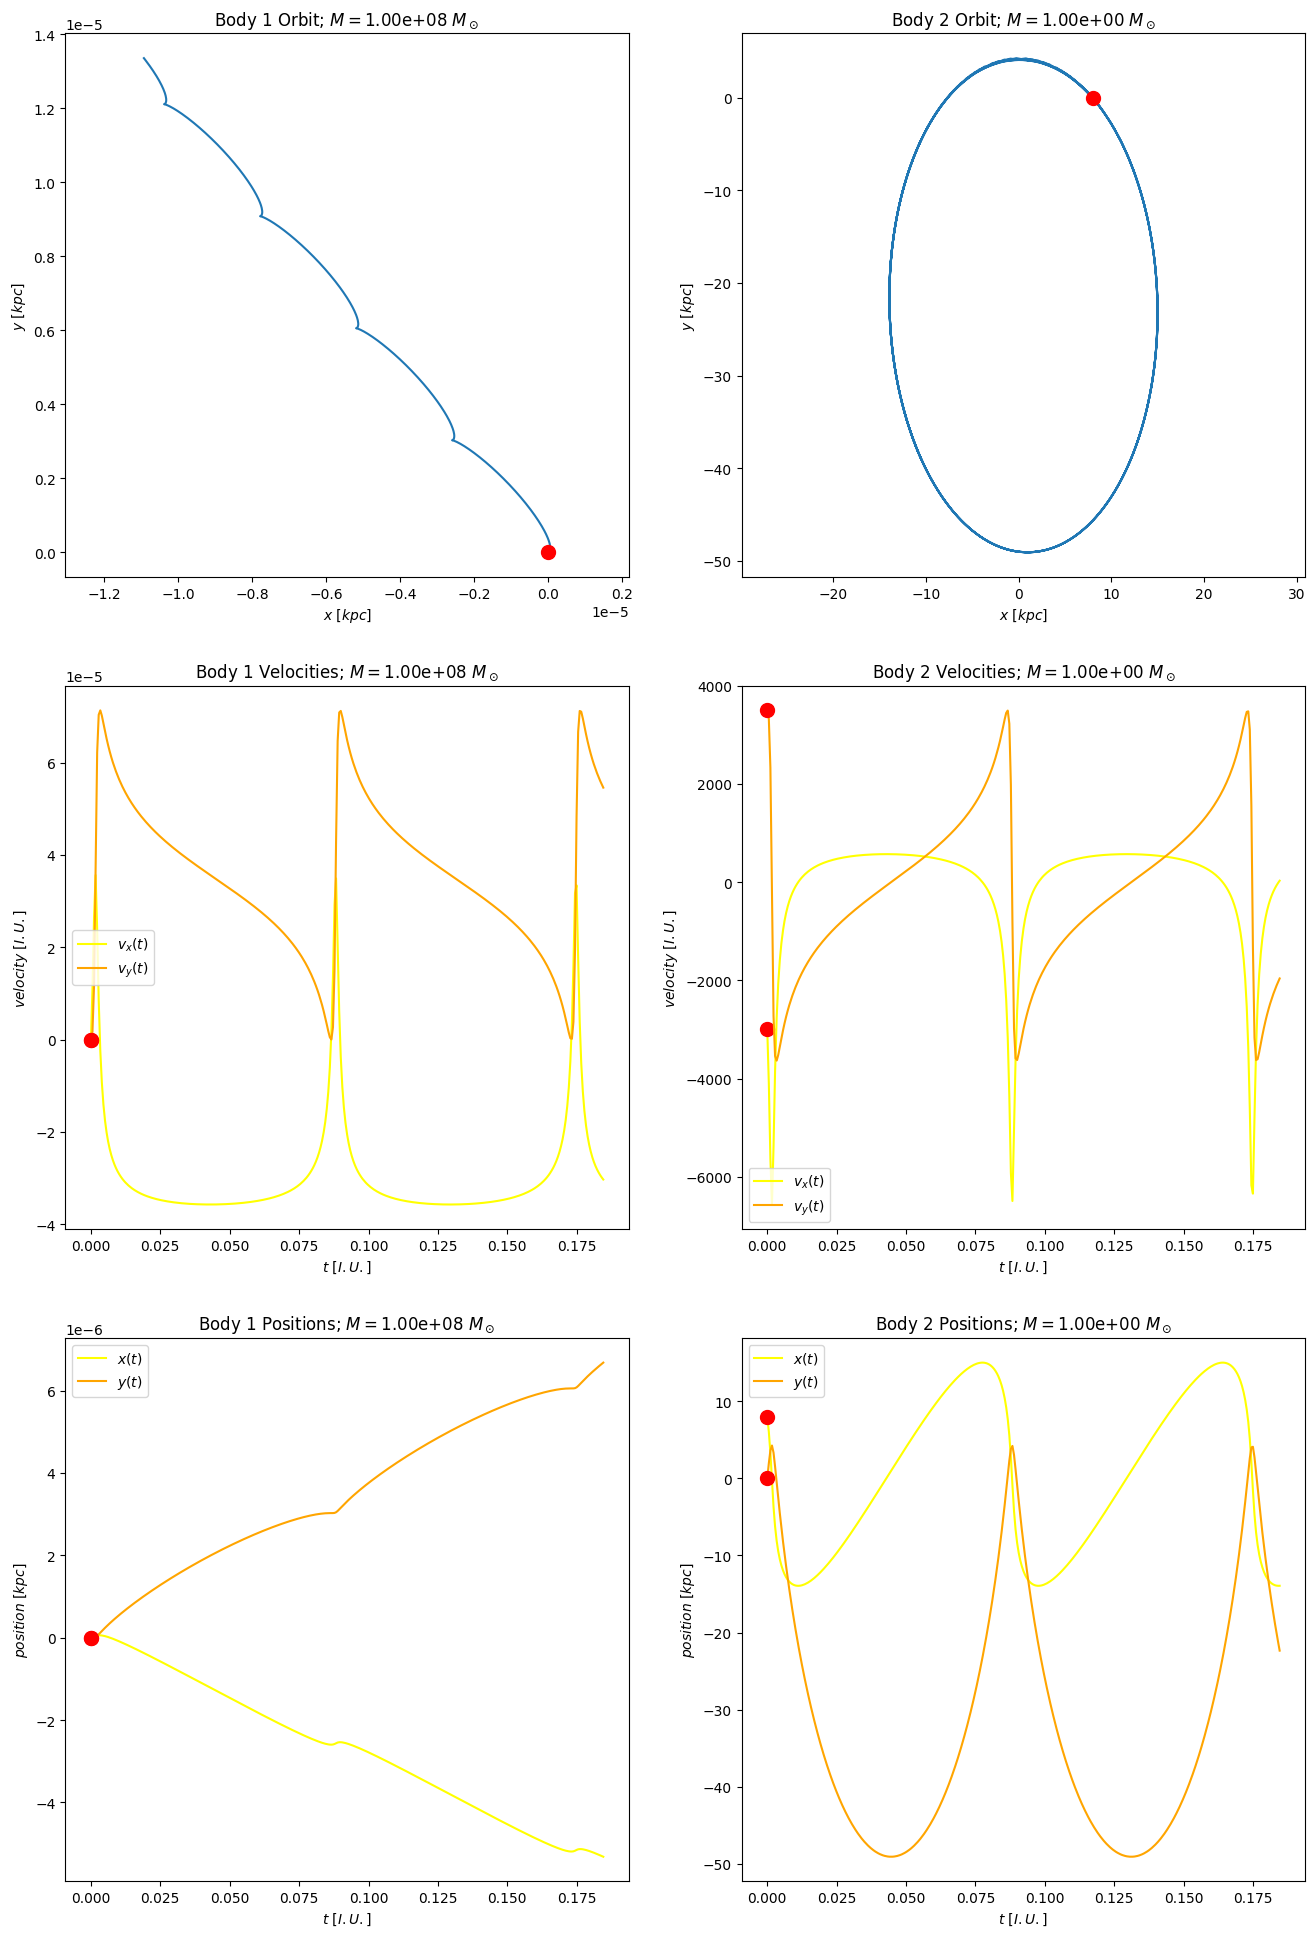

In [755]:
fig, ax = plt.subplots(3, 2, figsize=(16, 24))

for i in range(3):
      for j in range(2):
          if i == 0:
            ax[i][j].set_title("Body " + str(j+1) + " Orbit; $M=$" + "{:.2e}".format(snapshots[0][2][j][0]) + " " + mass_unit_str)

            ax[i][j].plot(pos[j][0], pos[j][1])
            ax[i][j].plot(pos[j][0][0], pos[j][1][0], color='red', marker='o',  markersize=10)

            ax[i][j].set_aspect('equal', 'datalim')
            ax[i][j].set_xlabel("$x$ " + "[" + distance_unit_str + "]")
            ax[i][j].set_ylabel("$y$ " + "[" + distance_unit_str + "]")
          elif i == 1:
            snapshot_stop_index = int(len(snapshots)/2)
            ax[i][j].set_title("Body " + str(j+1) + " Velocities; $M=$" + "{:.2e}".format(snapshots[0][2][j][0]) + " " + mass_unit_str)

            ax[i][j].plot(time_stamp[:snapshot_stop_index], vel[j][0][:snapshot_stop_index], color='yellow', label='$v_x(t)$')
            ax[i][j].plot(time_stamp[0], vel[j][0][0], color='red', marker='o',  markersize=10)

            ax[i][j].plot(time_stamp[:snapshot_stop_index], vel[j][1][:snapshot_stop_index], color='orange', label='$v_y(t)$')
            ax[i][j].plot(time_stamp[0], vel[j][1][0], color='red', marker='o',  markersize=10)

            ax[i][j].set_xlabel("$t$ " + "[$I.U.$]")
            ax[i][j].set_ylabel("$velocity$ " + "[$I.U.$]")
            ax[i][j].legend()
          elif i == 2:
            snapshot_stop_index = int(len(snapshots)/2)
            ax[i][j].set_title("Body " + str(j+1) + " Positions; $M=$" + "{:.2e}".format(snapshots[0][2][j][0]) + " " + mass_unit_str)

            ax[i][j].plot(time_stamp[:snapshot_stop_index], pos[j][0][:snapshot_stop_index], color='yellow', label='$x(t)$')
            ax[i][j].plot(time_stamp[0], pos[j][0][0], color='red', marker='o',  markersize=10)

            ax[i][j].plot(time_stamp[:snapshot_stop_index], pos[j][1][:snapshot_stop_index], color='orange', label='$y(t)$')
            ax[i][j].plot(time_stamp[0], pos[j][1][0], color='red', marker='o',  markersize=10)

            ax[i][j].set_xlabel("$t$ " + "[$I.U.$]")
            ax[i][j].set_ylabel("$position$ " + "[" + distance_unit_str + "]")
            ax[i][j].legend()

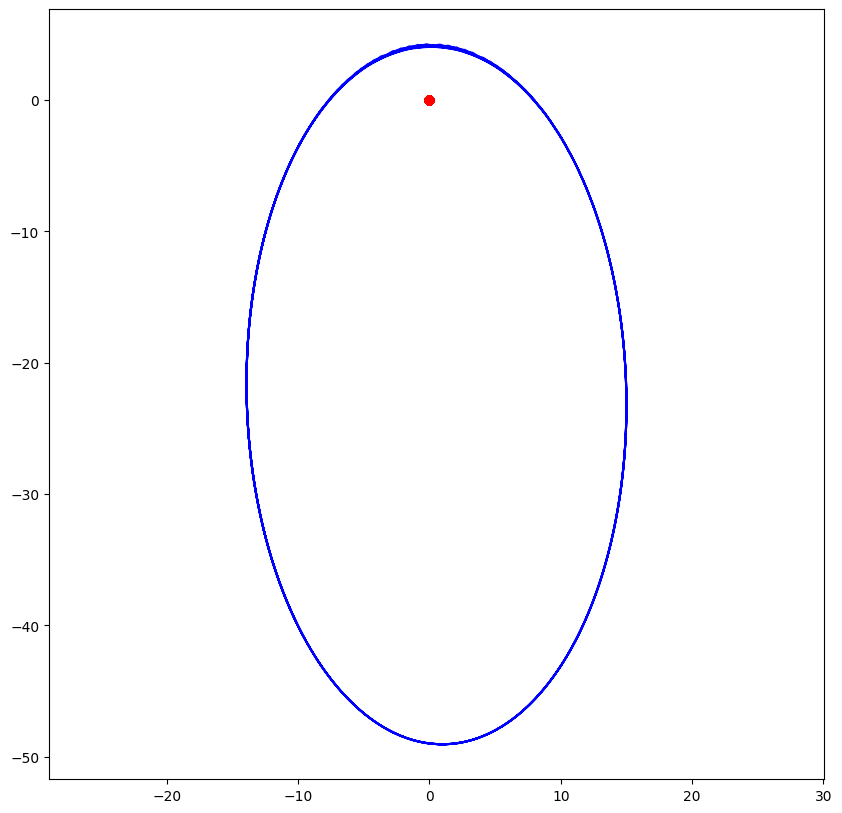

In [756]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

ax.scatter(pos[0][0], pos[0][1], color='red')
ax.plot(pos[1][0], pos[1][1], color='blue')
ax.set_aspect('equal', 'datalim')

In [757]:
print(get_aper(snapshots, 1, 'apo'))
print(get_aper(snapshots, 1, 'per'))
print(get_eccentricity(snapshots, 1))
print()
print(get_aper(snapshots, 0, 'apo'))
print(get_aper(snapshots, 0, 'per'))
print(get_eccentricity(snapshots, 0))

49.07297132212868
4.2613858816329895
0.8402010971894704

4.907297132212865e-07
4.261385881632989e-08
0.8402010971894703
